# Gaussian Process (GP)

* A GP is a **Gaussian distribution over functions**. Example: f is a GP if f(x) = [f(x1), f(x2),..., f(xn)] is Gaussian distributed for any vector [x1, x2, ..., xn]

* A GP is specified by a mean [mu(x1), ..., mu(xn)] and a covariance/kernel function K_{i, j} = k(xi, xj)

* Given a set of observed inputs, corresponding output values, and a Gaussian process prior, we can compute the posterior over the value f(x*) at any query input x*. How?

    * Find the joint distribution [f(x*), f(x1), ..., f(xn)]

    * Use the conditioning rules for a Gaussian to compute f(x*) | f(x1), ..., f(xn)

* GPs can handle noise versions of input values because [f(x*), f(y1), ..., f(yn)] with yi = xi + (white Gaussian noise) is also Gaussian

* The kernel parameters (length scale and noise variance) are chosen such that they maximize the log likelihood of the observed data (Don't forget to cross-validate!)

* Computational complextity:

    * O(N^3) computations to find the posterior mean weight vector and O(N c) to make a prediction, with N:=number of observations and c:=complexity of evaluating the kernel.
    * GPs scale badly, however, a linear kernel (aka Bayesian Linear Regression) can help: O(d^3) computations needed to find the posterior mean weight vector and O(d) to make predictions, with d:=dimension of the input

In [49]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, Matern
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

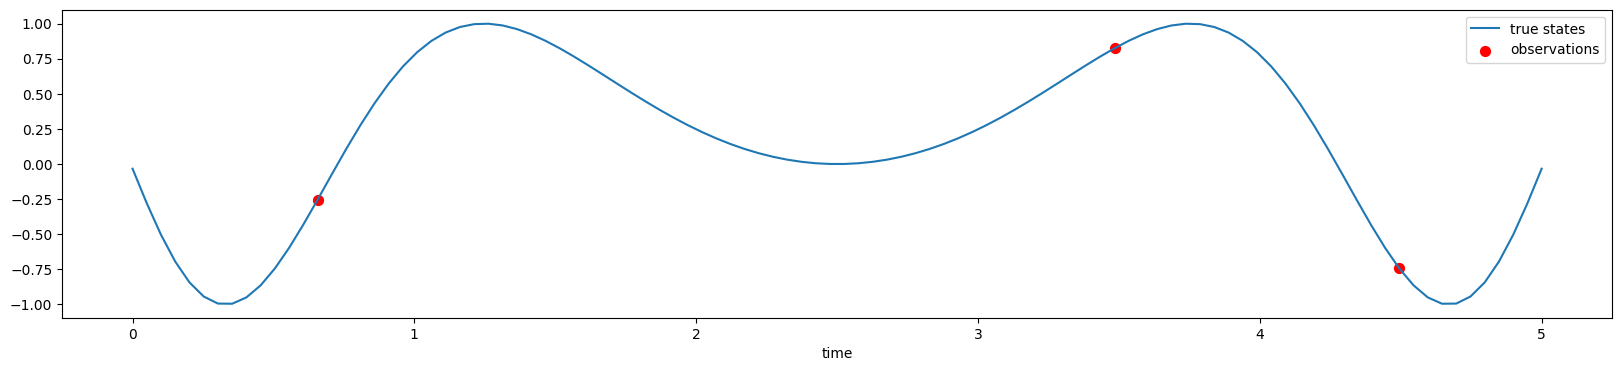

In [27]:
class GPStateEstimator:
    def __init__(self):
        self.n = 1           # counter of samples
        self.m_x = 1         # dimensionality of query inputs
        self.m_y = 1         # dimensionality of targets
        self.X_train = []    # [n samples, m_x features]
        self.y_train = []    # [n samples, m_y targets]
        self.kernel = RBF()        
        self.gp = GaussianProcessRegressor(kernel=self.kernel, random_state=0)   # Goal is to predict a continuous numerical value based on input data. 

    def set_kernel(self, kernel):
        self.kernel = kernel
        
    def update(self, x, y):
        # Model is updated in batch (all the evidence is given at once - offline learning)
        self.gp.fit(x, y)
                
    def predict(self, n, x):
        # Predict using the GP
        return self.gp.predict(np.array(x).reshape(n, self.m_x), return_std=True)    # query points of shape [n samples, n_x features]

    def sample(self, n, x, num_samples):
        # Draw samples from the GP and evaluate at X
        return self.gp.sample_y(np.array(x).reshape(n, self.m_x), num_samples)    # query points of shape [n time steps, n_x features]


# 0. Simulate noisy data
T = 100
timesteps = np.linspace(0, 5, T).reshape(-1, 1)
true_states = np.sin((timesteps - 2.5) ** 2).reshape(-1, 1)

# 0.1 We will use random points from sample trajectory to train our model
num_obs = 3
idx = np.random.choice(T, num_obs)
X_train = timesteps[idx]
y_train = true_states[idx]

fig = plt.figure(figsize=[20, 4])
plt.plot(timesteps, true_states, label='true states')
plt.scatter(X_train, y_train, marker='o', s=50, c='r', label='observations')
plt.xlabel("time")
plt.legend()
plt.show()

In [29]:
# 1. Create an instance of a GP regressor and compute posterior (estimates after observing sampled points)
estimator = GPStateEstimator()
# myK = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))  # A squared exponential kernel, alternatives include Laplace, Indicator, Linear
# myK = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0))            
# myK = Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e5))
myK = RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e5))
estimator.set_kernel(myK)
estimator.update(X_train, y_train)

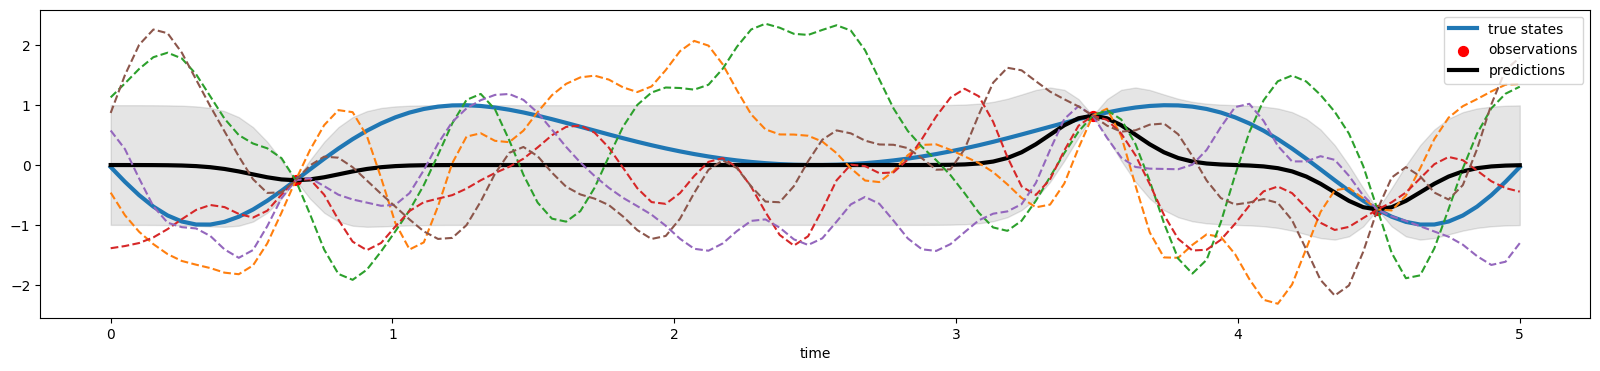

In [30]:
# 2. Compute the mean of the posterior and samples of the posterior distribution
n_samples = 5
y_mean, y_std = estimator.predict(T, timesteps)
y_samples = estimator.sample(T, timesteps, n_samples)

fig = plt.figure(figsize=[20, 4])
plt.plot(timesteps, true_states, linewidth=3.0, label='true states')
plt.scatter(X_train, y_train, marker='o', s=50, c='r', label='observations')

plt.plot(timesteps, y_mean, 'k', linewidth=3.0,  label='predictions')
plt.fill_between(timesteps[:, 0], y_mean - y_std, y_mean + y_std, alpha=0.1, color="black")

for i in range(n_samples):
    plt.plot(timesteps, y_samples[:, i], '--')

plt.xlabel("time")
plt.legend()
plt.show()

In [59]:
# Now we will use a GP to fill missing data of a hidden random walk

class RandomWalk:
    def __init__(self, a, q, r, T):
        self.a = a  # timescale
        self.q = q  # variance of process noise
        self.r = r  # variance of obs noise
        self.T = T  # horizon
        self.x = np.zeros(T)
        self.y = np.zeros(T)
        self.proc_noise = np.sqrt(q) * np.random.randn(T)
        self.obs_noise = np.sqrt(r) * np.random.randn(T)

    def initialize(self, init):
        self.x[0] = init
        
    def step(self, t):
        self.x[t] = a * self.x[t-1] + self.proc_noise[t-1]
        self.y[t] = self.x[t] + self.obs_noise[t-1]        

# Initialize random walker
T = 60
a = .9
q = 0.1
r = .05

walker = RandomWalk(a, q, r, T)
x0 = 10
walker.initialize(x0)

# Create a GP model
estimator = GPStateEstimator()
estimator.set_kernel(1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 10.0)))

# Simulate data
timesteps = np.arange(T).reshape(-1, 1)
for t in range(1, T):
    walker.step(t)        

num_obs = 10
idx = np.random.choice(T, num_obs)
X_train = timesteps[idx]
y_train = walker.y[idx]

# Train GP model
estimator.update(timesteps, walker.y)

# Once model is learned, GP can make predictions that fit missing data
prediction = estimator.predict(T, timesteps)
p_mean = prediction[0]
p_std = prediction[1]

# To compare performance, we will estimate missing data using a Kalman filter
A = np.array([[a]])
H = np.array([[1]])
Q = np.array([[q]])
R = np.array([[r]])

tmpA = A.T
tmpB = np.dot(A.T, H.T)
tmpQ = Q
tmpR = np.dot(np.dot(H, Q), H.T) + R
tmpE = np.eye(A.shape[0])
tmpS = np.dot(Q, H.T)

Pf = solve_discrete_are(tmpA, tmpB, tmpQ, tmpR, tmpE, tmpS)
K = np.dot(np.dot(Pf, H.T), np.linalg.inv(R))[0, 0]            
G = np.dot(np.eye(A.shape[0]) - np.dot(K, H), A)[0, 0]

kalman_estimate = np.zeros(T)
for t in range(1, T):
    kalman_estimate[t] = G * kalman_estimate[t-1] + K * walker.y[t]

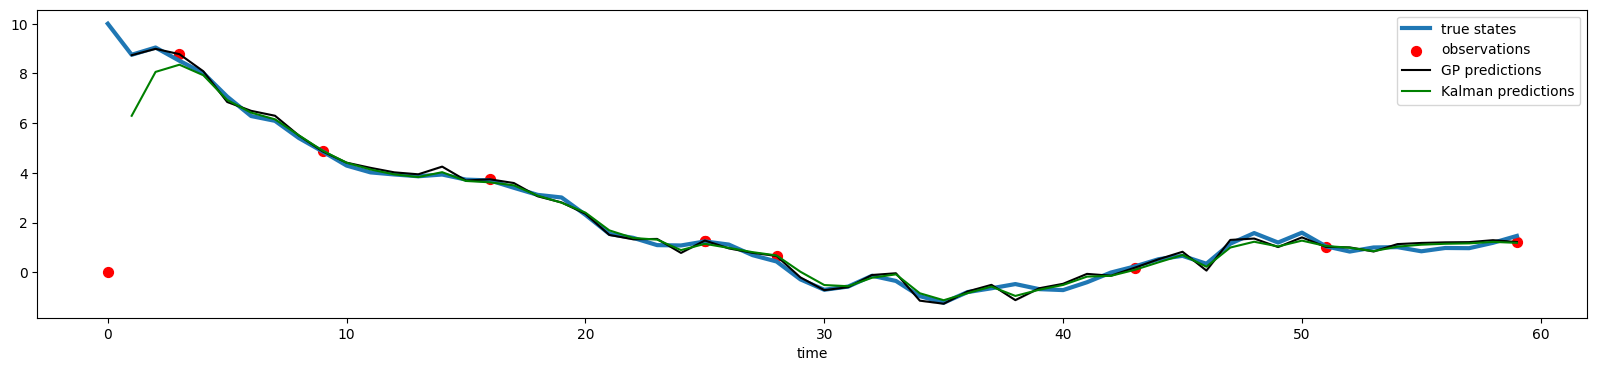

In [60]:
fig = plt.figure(figsize=[20, 4])
plt.plot(timesteps, walker.x, linewidth=3.0, label='true states')
plt.scatter(X_train, y_train, marker='o', s=50, c='r', label='observations')

plt.plot(timesteps[1:], p_mean[1:], 'k', linewidth=1.5,  label='GP predictions')
plt.fill_between(timesteps[1:, 0], p_mean[1:] - p_std[1:], p_mean[1:] + p_std[1:], alpha=0.1, color="black")

plt.plot(timesteps[1:], kalman_estimate[1:], 'g', linewidth=1.5,  label='Kalman predictions')

plt.xlabel("time")
plt.legend()
plt.show()